In [1]:
from typing import Sequence
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "6,7"

import torch
print(f"Discovered {torch.cuda.device_count()} CUDA devices.")

from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

from qumedl.models.autoencoder.vqvae import compute_vqvae_losses, find_symmetric_vqvae_input_lengths
from qumedl.models.autoencoder.vqvae.conv1d import Conv1DVQVAE
from qumedl.models.autoencoder.vqvae.quantizer.loss_fn import QuantizationLoss
from qumedl.training.collator import TensorBatchCollator, TensorBatch
from qumedl.models.recurrent.lstm import LSTM
from qumedl.mol.encoding.selfies_ import Selfies

Discovered 2 CUDA devices.


/opt/conda/envs/qumedl/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
random_seed = 42

In [3]:
def GPU_(i: int) -> str:
    n_visible_devices = torch.cuda.device_count()
    if i > n_visible_devices:
        raise ValueError("Device index out of bounds.")
    
    return f"cuda:{i}"


vqvae_device = GPU_(0)
lstm_device = GPU_(0)

In [4]:
selfies = Selfies.from_smiles_csv("/root/data/drug-discovery/10Kstoned_vsc_initial_dataset_insilico_chemistry42_filtered.csv")
symmetric_lengths = find_symmetric_vqvae_input_lengths(selfies.max_length, search_space_size=20, encoder_depth=3)
selfies.max_length = symmetric_lengths[0]

selfies, eval_selfies = selfies.train_test_split(0.95, shuffle=True, random_seed=random_seed)

Loading Selfies From CSV: 100%|██████████| 10000/10000 [00:04<00:00, 2279.81it/s]


In [5]:
vqvae = Conv1DVQVAE(
    vocab_size=selfies.n_tokens,
    embedding_dim=256,
    hidden_dim=128,
    residual_layer_hidden_dim=256,
    n_codes=512,
    hidden_activation_fn=nn.LeakyReLU(negative_slope=0.001),
    pad_token=tuple([selfies.pad_token, selfies.pad_index]),
    output_activation_fn=nn.Identity()
).to(vqvae_device)

In [6]:
train_selfies_dataset = selfies.as_dataset(include_start_token=False)

shuffler = torch.Generator()
shuffler.manual_seed(random_seed)

train_data_loader = DataLoader(
    train_selfies_dataset,
    batch_size=32,
    shuffle=True,
    generator=shuffler,
    collate_fn=TensorBatchCollator(),
)

optimizer = torch.optim.AdamW(
    vqvae.parameters(), 
    lr=5e-3,
    betas=(0.88, 0.995)
)

reconstruction_loss_fn = torch.nn.CrossEntropyLoss()
quantization_loss_fn = QuantizationLoss()

In [7]:
test_batch = next(iter(train_data_loader))
test_batch.to(vqvae_device)

In [8]:
# sanity check
vqvae.enable_debug_hooks()

# tensor = next(iter(dataloader))[0]
encoded = vqvae.encode(test_batch.inputs)
quantized, idxs = vqvae.quantizer(encoded)
decoded = vqvae.decode(quantized)

vqvae.disable_debug_hooks()
# print(tensor.shape, decoded.shape)

Embedding(input_embedding.0): [torch.Size([32, 425])] -> torch.Size([32, 425, 256])
Rearrange(input_embedding.1): [torch.Size([32, 425, 256])] -> torch.Size([32, 256, 425])
Conv1d(encoder.conv1): [torch.Size([32, 256, 425])] -> torch.Size([32, 64, 213])
BatchNorm1d(encoder.batch_norm_1): [torch.Size([32, 64, 213])] -> torch.Size([32, 64, 213])
ReLU(encoder.hidden_act): [torch.Size([32, 64, 213])] -> torch.Size([32, 64, 213])
Conv1d(encoder.conv2): [torch.Size([32, 64, 213])] -> torch.Size([32, 128, 107])
BatchNorm1d(encoder.batch_norm_2): [torch.Size([32, 128, 107])] -> torch.Size([32, 128, 107])
ReLU(encoder.hidden_act): [torch.Size([32, 128, 107])] -> torch.Size([32, 128, 107])
Conv1d(encoder.conv3): [torch.Size([32, 128, 107])] -> torch.Size([32, 128, 54])
BatchNorm1d(encoder.batch_norm_3): [torch.Size([32, 128, 54])] -> torch.Size([32, 128, 54])
ReLU(encoder.residual_stack.layers.0._block.0): [torch.Size([32, 128, 54])] -> torch.Size([32, 128, 54])
Conv1d(encoder.residual_stack.lay

In [9]:
import matplotlib.pyplot as plt


loss_history = {
    "loss": [],
    "q_loss": [],
    "rec_loss": []
}

n_epochs = 2

total_batches = n_epochs * len(train_data_loader)
with tqdm(total=total_batches) as pbar:
    for epoch in range(n_epochs):
        pbar.set_description(f"Epoch {epoch + 1}")
        tensor_batch: TensorBatch
        
        for tensor_batch in train_data_loader:
            tensor_batch.to(vqvae_device)
            rec_loss, q_loss = compute_vqvae_losses(
                vqvae,
                tensor_batch.inputs.long(),
                reconstruction_loss_fn,
                quantization_loss_fn
            )
            
            total_loss = rec_loss + q_loss
            total_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            step_losses = {
                "loss": total_loss.item(),
                "rec_loss": rec_loss.item(),
                "q_loss": q_loss.item()
            }
            
            pbar_formatted_step_losses = {k: round(v, 4) for k, v in step_losses.items()}
            
            pbar.set_postfix(pbar_formatted_step_losses)
            pbar.update()
            
            for k,v in step_losses.items():
                loss_history[k].append(v)

Epoch 2: 100%|██████████| 594/594 [00:05<00:00, 107.90it/s, loss=0.206, rec_loss=0.178, q_loss=0.0281]


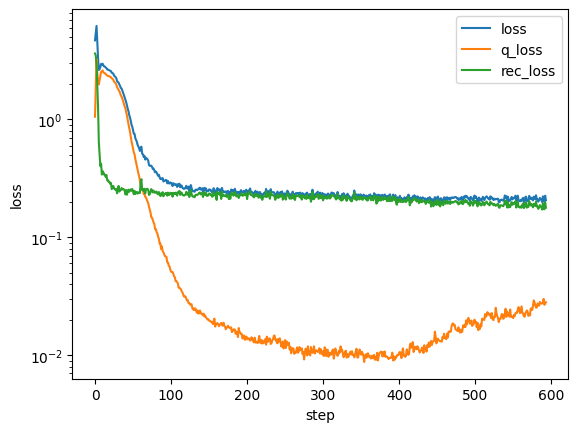

In [10]:
for k, v in loss_history.items():
    plt.plot(v, label=k)

plt.yscale('log')
plt.xlabel('step')
plt.ylabel('loss')
plt.legend()
plt.show()

In [11]:
# test reconstruction
test_molecules = selfies.mol_strings[:4]
print(test_molecules)
test_molecules_tensor = torch.from_numpy(selfies.asarray()[:4]).to(vqvae_device)

with torch.no_grad():
    quantized = vqvae.encode_quantize(test_molecules_tensor)
    reconstructed = vqvae.decode(quantized)

reconstructed_labels = reconstructed.argmax(dim=1).cpu().numpy()
reconstruction_strings = selfies.decode(reconstructed_labels)
print(reconstruction_strings)

['[C][C][Branch1][Branch1][C][C][C][N][C][C][=N][C][=C][Branch1][Ring2][NH1][Ring1][Branch1][C][C][N][Branch1][=C][C][=C][C][=C][C][=C][Ring1][=Branch1][C][Branch1][C][C][C][C][Ring1][S]', '[C][C][N][C][C][N][Branch2][Ring2][=N][C][=N][C][Branch1][#C][C][C][Branch1][Ring1][C][C][C][C][C][N][Ring1][#Branch1][C][C][=N][C][Branch1][C][F][=C][Ring1][P][C][=N][C][C][=C][C][=C][C][=C][Ring1][=Branch1][C][=C][N][Ring1][Branch1][C][C][C][Ring2][Ring2][Ring2]', '[C][C][N][C][C][C][Ring1][Ring2][C][N][C][=N][C][Branch1][#C][O][C][C][C][C][C][N][Ring1][Branch1][C][C][C][Ring1][Branch2][=N][C][=N][C][Branch1][=N][C][=C][C][=C][C][Branch1][C][F][=C][Ring1][#Branch1][C][=C][Branch1][C][F][C][=C][Ring2][Ring1][=N][Ring1][#C]', '[C][C][C][C][N][Branch2][Ring2][O][C][=N][C][Branch1][O][C][O][C][C][C][C][C][O][Ring1][Branch1][=C][Branch2][Ring1][Ring1][N][C][=C][N][=C][C][=C][C][=C][C][Branch1][C][C][=C][Ring1][O][Ring1][#Branch1][C][C][Ring2][Ring1][#Branch2][C][C][N][Ring2][Ring1][S]']
['[C][C][C][Bra